# Header files

In [259]:
import pandas as pd 
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from collections import Counter

# Type of cells and neurons

In [2]:
def ntype(n):
    n = nclass(n)
    if n not in neuron_list:
        n = nclass(class_members(n)[0])

    if n in (
        'ADF', 'ADL', 'AFD', 'ALM', 'ALN', 'AQR', 'ASE', 'ASG', 'ASH', 'ASI',
        'ASJ', 'ASK', 'AUA', 'AVM', 'AWA', 'AWB', 'AWC', 'BAG', 'DVA', 'FLP',
        'IL2', 'OLL', 'OLQ', 'PHA', 'PHB', 'PHC', 'PLM', 'PLN', 'PQR', 'PVD',
        'PVM', 'SAA', 'SDQ', 'URB', 'URX', 'URY'
    ):
        return 'sensory'
    if n in (
        'ADA', 'AIA', 'AIB', 'AIN', 'AIY', 'AIZ', 'AVA', 'AVB', 'AVD', 'AVE',
        'AVG', 'BDU', 'LUA', 'PVC', 'PVP', 'PVR', 'PVT', 'PVW',
        'RIA', 'RIB', 'RIF', 'RIG', 'RIH', 'RIM', 'RIR', 'RIP', 'AVJ',
    ):
        return 'inter'
    if n in (
        'ASn', 'DAn', 'DBn', 'DDn', 'DVB', 'IL1', 'PDA', 'PDB', 'RIV', 'RMD',
        'RME', 'RMF', 'RMH', 'SAB', 'SIA', 'SIB', 'SMB', 'SMD', 'URA', 'VAn',
        'VBn', 'VCn', 'VDn',
    ):
        return 'motor'
    if n in (
        'ADE', 'AIM', 'ALA', 'AVF', 'AVH', 'AVK', 'AVL', 'CEP', 'HSN',
        'PDE', 'PVQ', 'PVN', 'RIC', 'RID', 'RIS', 'RMG', 'DVC',
    ):
        return 'modulatory'
    if n in (
        'BWM01', 'BWM02', 'BWM03', 'BWM04', 'BWM05', 'BWM06', 'BWM07', 'BWM08'
    ):
        return 'muscle'
    if n in ('CAN', 'CEPsh', 'GLR', 'excgl', 'hyp'):
        return 'other'
    print(n, 'is not a valid neuron')
    return 'nonvalid'

# File imports

In [70]:
all_datasets = ('Dataset1', 'Dataset2', 'Dataset3', 'Dataset4', 'Dataset5', 'Dataset6', 'Dataset7', 'Dataset8')

Node_name = ['ADFL','ADFR','ADLL','ADLR','AFDL','AFDR','ALML','ALMR','ALNL','ALNR','AQR','ASEL','ASER','ASGL','ASGR','ASHL','ASHR','ASIL','ASIR','ASJL','ASJR','ASKL','ASKR','AUAL','AUAR','AVM','AWAL','AWAR','AWBL','AWBR','AWCL','AWCR','BAGL','BAGR','DVA','FLPL','FLPR','IL2DL','IL2DR','IL2L','IL2R','IL2VL','IL2VR','OLLL','OLLR','OLQDL','OLQDR','OLQVL','OLQVR','PLNL','PLNR','SAADL','SAADR','SAAVL','SAAVR','SDQL','SDQR','URBL','URBR','URXL','URXR','URYDL','URYDR','URYVL','URYVR','ADAL','ADAR','AIAL','AIAR','AIBL','AIBR','AINL','AINR','AIYL','AIYR','AIZL','AIZR','AVAL','AVAR','AVBL',
             'AVBR','AVDL','AVDR','AVEL','AVER','AVJL','AVJR','BDUL','BDUR','PVCL','PVCR','PVPL','PVPR','PVR','PVT','RIAL','RIAR','RIBL','RIBR','RIFL','RIFR','RIGL','RIGR','RIH','RIML','RIMR','RIPL','RIPR','RIR','IL1DL','IL1DR','IL1L','IL1R','IL1VL','IL1VR','RIVL','RIVR','RMDDL','RMDDR','RMDL','RMDR','RMDVL','RMDVR','RMED','RMEL','RMER','RMEV','RMFL','RMFR','RMHL','RMHR','SIADL','SIADR','SIAVL','SIAVR','SIBDL','SIBDR','SIBVL','SIBVR','SMBDL','SMBDR','SMBVL','SMBVR','SMDDL','SMDDR','SMDVL','SMDVR','URADL','URADR','URAVL','URAVR','ADEL','ADER','AIML','AIMR','ALA','AVFL','AVFR','AVHL',
             'AVHR','AVKL','AVKR','AVL','CEPDL','CEPDR','CEPVL','CEPVR','DVC','HSNL','HSNR','PVNL','PVNR','PVQL','PVQR','RICL','RICR','RID','RIS','RMGL','RMGR','BWM-DL01','BWM-DR01','BWM-VL01','BWM-VR01','BWM-DL02','BWM-DR02','BWM-VL02','BWM-VR02','BWM-DL03','BWM-DR03','BWM-VL03','BWM-VR03','BWM-DL04','BWM-DR04','BWM-VL04','BWM-VR04','BWM-DL05','BWM-DR05','BWM-VL05','BWM-VR05','BWM-DL06','BWM-DR06','BWM-VL06','BWM-VR06','BWM-DL07','BWM-DR07','BWM-VL07','BWM-VR07','BWM-DL08','BWM-DR08','BWM-VL08','BWM-VR08','CANL','CANR','CEPshDL','CEPshDR','CEPshVL','CEPshVR','GLRDL','GLRDR','GLRL','GLRR','GLRVL','GLRVR']

Post_emb = ['ALNL','ALNR','AQR','AVM','PLNL','PLNR','SDQL','SDQR','RMFL','RMFR','RMHL','RMHR','AVFL','AVFR','HSNL','HSNR','PVNL','PVNR']

timepoint = {
    'Dataset1': 0,
    'Dataset2': 5,
    'Dataset3': 8,
    'Dataset4': 16,
    'Dataset5': 23,
    'Dataset6': 27,
    'Dataset7': 50,
    'Dataset8': 50,
}

stage = {   
    'Dataset1': 'L1',
    'Dataset2': 'L1',
    'Dataset3': 'L1',
    'Dataset4': 'L1',
    'Dataset5': 'L2',
    'Dataset6': 'L3',
    'Dataset7': 'Adult',
    'Dataset8': 'Adult'
}

larval_stage_ends = [0, 16, 25, 34, 45]
larval_stage_mids = [8, 20.5, 29.5, 39.5, 50]
larval_stage_labels = ['L1', 'L2', 'L3', 'L4', '  Adult']

data = []
data.append('Synapse raw data')

for dataset_number in range(1, 9):
    data.append(pd.read_excel('media-2.xlsx', sheet_name=f"Dataset{dataset_number}", 
                              index_col=0, header=2, 
                              skiprows=[3], usecols=range(2,183)))
    for i in Node_name[180:]:
        data[-1][i] = 0

In [4]:
nx_G = []
nx_G.append('Synapse networkx data')

for dataset_number in range(1, 9):    
    nx_G.append(nx.from_numpy_matrix(data[dataset_number].T.values, create_using=nx.DiGraph))
    
# for dataset_number in range(1, 9):
#     nx.write_gml(nx_G[dataset_number], f'network{dataset_number}.gml')

# Plots

In [238]:
def plot_graph(data, yticks, y_name, size=3):
    fig, ax = plt.subplots(figsize=(size, size*0.75), dpi=150)
       
    x_ticks = list(timepoint.values())     
    plt.scatter(x_ticks, data, zorder=2)
    
    min_x = 0
    max_x = 50
    x_new = np.linspace(min_x, max_x, 100)
    rbf = Rbf(x_ticks, data, function = 'thin_plate', smooth = 0.1)
    y_smooth = rbf(x_new)
    plt.plot(x_new, y_smooth, zorder=1, color='black')
    
    ax.set_xlim([min_x-5, max_x+5])
    ax.set_xticks([min_x-5])
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_xticks(larval_stage_mids, minor=True)
    ax.set_xticklabels(larval_stage_labels, minor=True)
    ax.tick_params(axis='x', which='minor', bottom=False, pad=1)
    
    for t in larval_stage_ends:
        plt.axvline(t, color='#999999', linestyle='dotted', linewidth=1, zorder=-1)
    
    ax.set_yticks(yticks)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    
    plt.ylabel(y_name)
    plt.xlabel('Developmental age')
    plt.show()

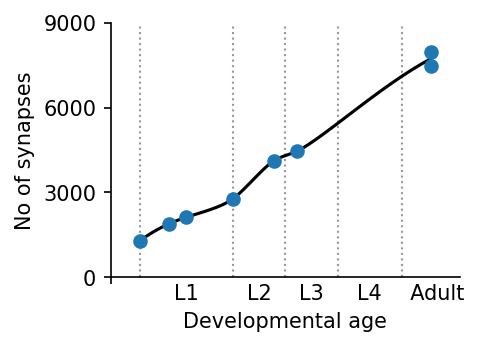

In [239]:
no_of_synapses = []
for dataset_number in range(1, 9):    
    no_of_synapses.append(sum(data[dataset_number].sum()))
plot_graph(no_of_synapses, [0,3000,6000,9000], 'No of synapses')

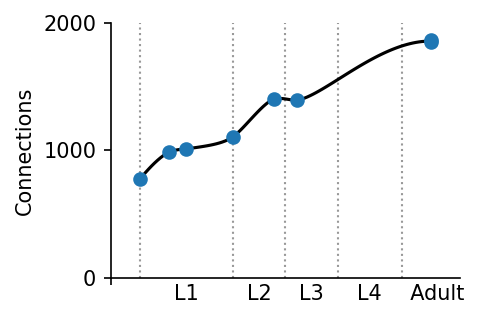

In [161]:
connections = []
for dataset_number in range(1, 9):    
    connections.append(sum(data[dataset_number].drop(Post_emb, axis=1).drop(Post_emb, axis=0).astype(bool).sum()))
plot_graph(connections, [0,1000,2000], 'Connections')

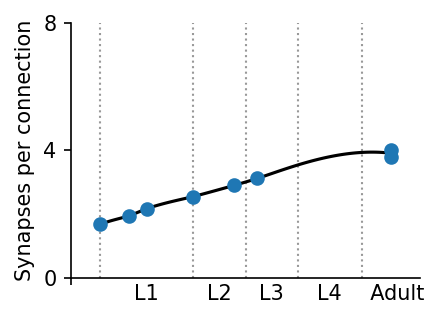

In [110]:
sum_pd_1 = data[1].drop(Post_emb, axis=1).drop(Post_emb, axis=0).sum(axis=0)
sum_pd_2 = data[1].drop(Post_emb, axis=1).drop(Post_emb, axis=0).sum(axis=1)
birth_neuron_from = set()
birth_neuron_to = set()
for ind in range(len(sum_pd)):
    if sum_pd_1[ind]>0:
        birth_neuron_from.add(sum_pd_1.index[ind])
    if sum_pd_2[ind]>0:
        birth_neuron_to.add(sum_pd_2.index[ind])
        
synapses_per_connection = []
for dataset_number in range(1, 9):
    synapses_per_connection.append(sum(data[dataset_number].loc[birth_neuron_to-set(Post_emb), birth_neuron_from-set(Post_emb)].sum())/sum(data[dataset_number][data[dataset_number]>0].loc[birth_neuron_to-set(Post_emb), birth_neuron_from-set(Post_emb)].count()))
    
plot_graph(synapses_per_connection, [0,4,8], 'Synapses per connection')

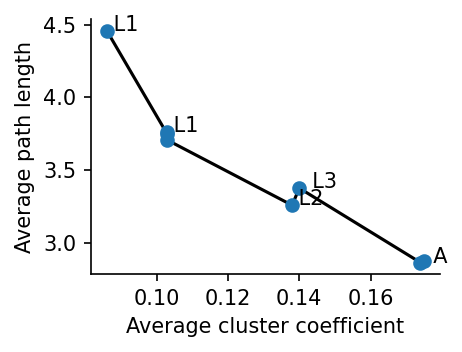

In [247]:
cytoscape_cluster_coeff =       [0.086,0.103,0.103,0.103,0.138,0.140,0.174,0.175]
cytoscape_average_path_length = [4.457,3.744,3.762,3.705,3.257,3.375,2.863,2.873]


fig, ax = plt.subplots(figsize=(3, 3*0.75), dpi=150)
ax.scatter(cytoscape_cluster_coeff, cytoscape_average_path_length, zorder=2)
ax.plot(cytoscape_cluster_coeff, cytoscape_average_path_length, zorder=1, color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)  

for i, txt in enumerate([' L1', '', ' L1', '', ' L2', '  L3', '  A', '']):
    ax.annotate(txt, (cytoscape_cluster_coeff[i], cytoscape_average_path_length[i]), fontsize=10)
    
plt.ylabel('Average path length')
plt.xlabel('Average cluster coefficient')
    
plt.show()

In [264]:
max(dict(nx_G[1].in_degree()).values())

19

In [262]:
def plot_degree_distribution(degrees, max_degree, xfreg=1):
    c = Counter(degrees)
    d = [0 for i in range(max_degree+1)]
    
    for i in range(max_degree+1): 
        d[i] = c[i]
        
    plt.plot(range(max_degree+1), d)
    plt.bar( range(max_degree+1), d)
    plt.xticks(range(0, max_degree+1, xfreg))
    plt.gca().set(title='Degree distribution', ylabel='Frequency', xlabel="Degree")
    plt.show()
    return

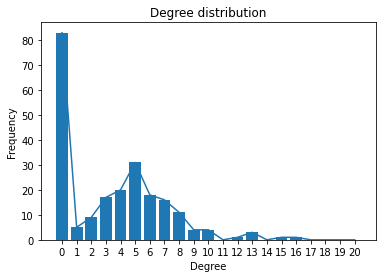

In [266]:
plot_degree_distribution(dict(nx_G[1].out_degree()).values(),20)

In [218]:

for dataset_number in range(1, 9):
    print(nx.average_clustering(nx_G[dataset_number]))

0.09097465989790472
0.10778399246529337
0.10781564640658516
0.10901264537740733
0.1440133737651729
0.1475169855727534
0.18184208505329846
0.18608413815685645


In [222]:
list(stage.values())

['L1', 'L1', 'L1', 'L1', 'L2', 'L3', 'Adult', 'Adult']

In [186]:
for dataset_number in [2, 3, 4, 5, 6, 8]:
    edges_birth = edges_birth.intersection(nx_G[dataset_number].edges())

In [217]:
for dataset_number in range(1, 9):
    nx.write_gml(nx_G[dataset_number], f'network{dataset_number}.gml')

In [181]:
nx_G[2].edges()

OutEdgeView([(0, 23), (0, 73), (0, 75), (0, 95), (0, 108), (0, 135), (0, 137), (0, 139), (0, 141), (0, 159), (1, 24), (1, 34), (1, 76), (1, 96), (1, 108), (1, 158), (2, 21), (2, 43), (2, 67), (2, 69), (2, 81), (2, 85), (3, 22), (3, 31), (3, 44), (3, 68), (3, 70), (3, 81), (3, 86), (3, 142), (4, 73), (5, 74), (6, 87), (6, 163), (7, 88), (7, 100), (7, 164), (11, 30), (11, 31), (11, 69), (11, 70), (11, 73), (11, 74), (12, 4), (12, 31), (12, 67), (12, 69), (12, 70), (12, 73), (12, 74), (12, 75), (13, 67), (13, 69), (13, 153), (14, 12), (14, 68), (14, 154), (15, 0), (15, 21), (15, 67), (15, 69), (15, 75), (15, 77), (15, 79), (15, 81), (15, 85), (15, 99), (16, 27), (16, 66), (16, 68), (16, 70), (16, 80), (16, 82), (16, 86), (16, 96), (16, 142), (16, 173), (17, 2), (17, 30), (18, 30), (18, 31), (18, 215), (19, 21), (19, 172), (19, 173), (19, 214), (19, 216), (20, 22), (20, 173), (20, 217), (21, 19), (21, 67), (22, 68), (22, 100), (23, 77), (23, 83), (23, 95), (23, 97), (24, 78), (24, 84), (24

# Extra

In [109]:
sum_pd_1 = data[1].drop(Post_emb, axis=1).drop(Post_emb, axis=0).sum(axis=0)
sum_pd_2 = data[1].drop(Post_emb, axis=1).drop(Post_emb, axis=0).sum(axis=1)
birth_neuron_from = set()
birth_neuron_to = set()
for ind in range(len(sum_pd)):
    if sum_pd_1[ind]>0:
        birth_neuron_from.add(sum_pd_1.index[ind])
    if sum_pd_2[ind]>0:
        birth_neuron_to.add(sum_pd_2.index[ind])

In [71]:
temp_sum = []
for dataset_number in range(1, 9):
    temp_sum.append(sum(data[dataset_number][birth_neuron].sum()))
print(temp_sum)

[1296, 1889, 2107, 2739, 3965, 4262, 6971, 7394]


In [98]:
sum_pd = data[1].sum(axis=0)
birth_neuron = set()
for ind in range(len(sum_pd)):
    if sum_pd[ind]>0:
        birth_neuron.add(sum_pd.index[ind])

In [155]:
np.count_nonzero(data[2].loc[birth_neuron_to-set(Post_emb), birth_neuron_from-set(Post_emb)].values)

950

In [154]:
sum([17, 15,  5,  1,  1,  5,  0,  1,  4,  3,  1,  2,  3,  5,  3,  9,  4,
        6, 11,  5,  3,  2, 10, 10,  3,  4,  6,  7,  3,  3,  1,  8,  4, 15,
        4,  8, 16,  2,  1,  6, 16,  5,  2,  2, 10, 11, 15,  3,  4,  7,  6,
       15,  3,  4,  4,  5,  2,  5, 13,  1,  1,  9, 14,  4,  5, 14,  3,  7,
        2, 11,  6,  5,  2,  1,  4, 12,  5,  7, 18,  4,  3,  6,  2,  6, 20,
        2,  5,  7,  3, 18, 14,  2,  2,  2,  4,  3, 13,  7,  6,  5,  4,  0,
        4,  3,  4,  3, 20,  3, 16,  2,  5,  8,  4,  3,  2, 15, 13,  7,  5,
        4,  7,  4, 11,  5, 13,  2, 10,  4,  5, 11,  2,  2,  5,  1,  6,  2,
        1,  6,  4,  6,  4,  2,  4,  3,  9,  5,  9,  3,  3,  6,  3,  4,  7,
        1,  4,  6,  9,  1,  4,  3,  1,  2,  3,  1,  4,  3])

950

In [158]:
temp = pd.DataFrame()
for from_neuron in birth_neuron_from:
    from to_neuron in birth_neuron_to:

In [159]:
temp

,pre
0,AIBR
1,AVKR
2,ASJR
3,ADFR
4,ASIR
...,...
136,ASHL
137,BDUR
138,PVPR
139,ADEL


In [45]:
import numpy as np
from nature2021.src.data import data_manager
from nature2021.src.data.neuron_info import neuron_list, in_brain, class_members, ntype, npair, nclass, is_postemb, contralateral

In [46]:
G = data_manager.get_connections()['count'].copy()
G = data_manager.remove_postemb(G)

In [141]:
G_from_birth =  G[G['Dataset1'] > 0]
syn_count = G_from_birth.apply(lambda s: s[s>0].count())

In [129]:
syn_count

dataset
Dataset1    1296
Dataset2    1417
Dataset3    1538
Dataset4    1936
Dataset5    2617
Dataset6    2753
Dataset7    4010
Dataset8    4343
dtype: int64

In [142]:
syn_count

dataset
Dataset1    775
Dataset2    588
Dataset3    562
Dataset4    594
Dataset5    620
Dataset6    600
Dataset7    633
Dataset8    634
dtype: int64

In [76]:
syn_count

dataset
Dataset1    1.672258
Dataset2    2.409864
Dataset3    2.736655
Dataset4    3.259259
Dataset5    4.220968
Dataset6    4.588333
Dataset7    6.334913
Dataset8    6.850158
dtype: float64

In [114]:
names1 = set()
names2 = set()
for i in G_from_birth.index:
    names1.add(i[0])
for i in G_from_birth.index:
    names2.add(i[1])

In [150]:
len(names1.union(birth_neuron_from) - names1.intersection(birth_neuron_from))

0

In [116]:
len(names2.union(birth_neuron_to) - names2.intersection(birth_neuron_to))

0

In [108]:
data[1].drop(Post_emb, axis=1).drop(Post_emb, axis=0).sum(axis=1)

ADFL     7
ADFR     5
ADLL     2
ADLR     3
AFDL     4
        ..
GLRDR    1
GLRL     4
GLRR     0
GLRVL    4
GLRVR    2
Length: 206, dtype: int64

In [106]:
sum_pd = data[1].loc[temp,:].sum(axis=1)
neuron2 = set()
for ind in range(len(sum_pd)):
    if sum_pd[ind]>0:
        neuron2.add(sum_pd.index[ind])